# Settings in real data

In [1]:
%matplotlib inline

from nilearn import plotting
import nibabel as nib
import os
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np

from nilearn.image import new_img_like


In [2]:
si2_img = nib.load(os.path.join('..', 'zmeta_rocs', 'pre', 'scaled', 'varcopes.nii.gz'))
hatbeta_img = nib.load(os.path.join('..', 'zmeta_rocs', 'pre', 'scaled', 'copes.nii.gz'))
tau2_img = nib.load(os.path.join('..', 'zmeta_rocs', 'results', 'megaMFX', 'stats', 'mean_random_effects_var1.nii.gz'))

In [3]:
si2 = si2_img.get_data()
si2.shape
num_studies = si2.shape[3]

In [4]:
tau2=tau2_img.get_data()
tau2.shape

(91, 109, 91)

In [5]:
in_mask = np.nonzero(tau2>0)

In [6]:
hatbeta = hatbeta_img.get_data()

In [7]:
slices = range(-30, 42, 16)

## Heterogeneity test

### Cochran's Q statistic for heterogeneity

In [8]:
FFX_cope1_img = nib.load(
    os.path.join('..', 'zmeta_rocs', 'results', 'megaFFX_FSL', 'stats', 'cope1.nii.gz'))
FFX_cope1 = FFX_cope1_img.get_data()

In [9]:
FFX_cope1_inmask = FFX_cope1[in_mask]

Q = 0
for k in range(num_studies):
    curr_si2 = si2[...,k]
    curr_si2 = curr_si2[in_mask]
    curr_hatbeta = hatbeta[...,k]
    curr_hatbeta = curr_hatbeta[in_mask]
    w_i = np.divide(1, curr_si2)
    Q = Q + np.multiply(w_i, np.square(curr_hatbeta-FFX_cope1_inmask))

Q_inmask = Q
Q = np.zeros(tau2.shape)
Q[in_mask] = Q_inmask
Q_img = new_img_like(tau2_img, Q)

nan


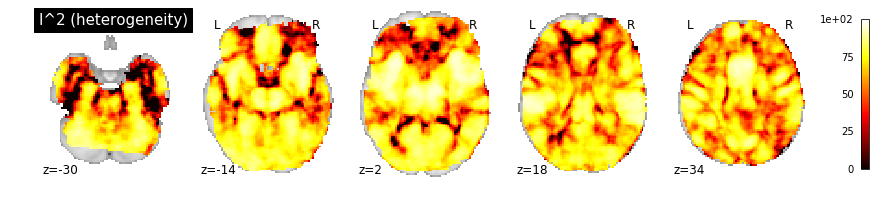

In [10]:
I2_inmask = (Q_inmask-(num_studies-1))/Q_inmask*100
I2 = np.ones(tau2.shape)*np.nan

# We use 0.00001 rathen than zero so that not considered as background in plot_stat_map
I2_inmask[I2_inmask<0] = 0.00001
I2[in_mask] = I2_inmask
I2_img = new_img_like(tau2_img, I2)
print(np.mean(I2))

plotting.plot_stat_map(I2_img, colorbar=True, display_mode='z',
                      cut_coords = slices, title='I^2 (heterogeneity)', vmax=100)


In [11]:
import scipy

# Uncorrected p-values for Cochran's Q 
Qp_inmask = scipy.stats.chi2.sf(Q_inmask, num_studies-1, loc=0, scale=1)
Qp_mlog10 = np.zeros(tau2.shape)
Qp_mlog10[in_mask] = -np.log10(Qp_inmask)
Qp_mlog10_img = new_img_like(tau2_img, Qp_mlog10)

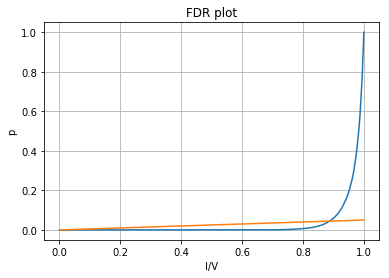

In [12]:
# FDR-corrected p-values for Cochran's Q 
import matplotlib.pyplot as plt
import numpy as np

def fdr(p,q):
#     Adapated from Thomas Nichols's implementation for Matlab available at: 
# https://www2.warwick.ac.uk/tenichols/software/fdr/FDR.m

    p = np.sort(p)
    V = len(p)
    I = range(1, V+1)
    
    cVID = 1
    cVN = sum(np.divide(1, range(1, V+1)))
    
    thresh_val = (np.divide(I, V)*q/cVID)

    plt.plot(np.divide(I, V), p)
    plt.plot(np.divide(I, V), thresh_val)

    plt.xlabel('I/V')
    plt.ylabel('p')
    plt.title('FDR plot')
    plt.grid(True)
    plt.show()
    
    pID = np.max(p[p<=thresh_val])
    return(pID)

pFDR = fdr(Qp_inmask, 0.05)

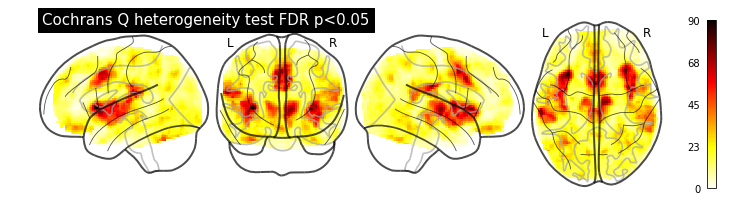

In [13]:
plotting.plot_glass_brain(Qp_mlog10_img, colorbar=True, threshold=-np.log10(pFDR), display_mode='lyrz', 
                          title='Cochrans Q heterogeneity test FDR p<0.05')

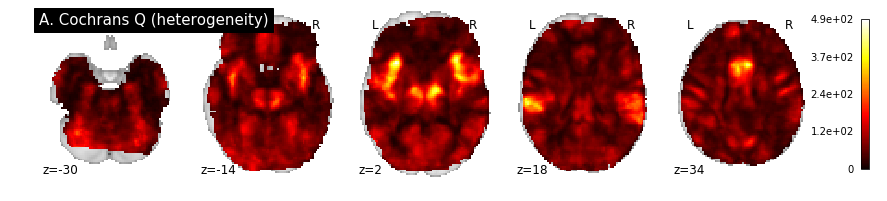

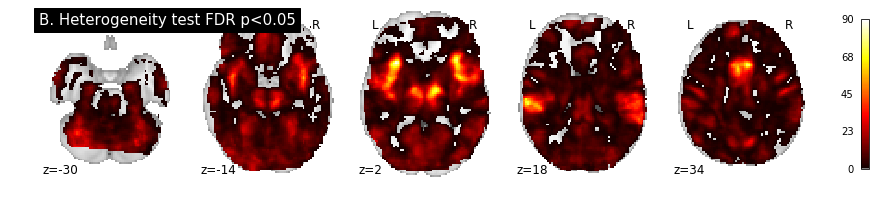

In [25]:
plotting.plot_stat_map(Q_img, colorbar=True, threshold=0, display_mode='z',
                      cut_coords = slices, title='A. Cochrans Q (heterogeneity)')
plt.savefig('heterogeneity_Q.pdf', format='pdf', dpi=300)
# plotting.plot_stat_map(I2_img, colorbar=True, threshold=0, display_mode='z',
#                       cut_coords = slices, title='I^2 (heterogeneity)', vmax=100)
# plt.savefig('heterogeneity_I2.pdf', format='pdf', dpi=300)
plotting.plot_stat_map(Qp_mlog10_img, colorbar=True, threshold=-np.log10(pFDR), display_mode='z', 
                        cut_coords = slices,   title='B. Heterogeneity test FDR p<0.05')
plt.savefig('heterogeneity_test.pdf', format='pdf', dpi=300)

In [15]:
### Percentage of voxels displaying significant heterogeneity
sum(Qp_mlog10[in_mask]>-np.log10(pFDR))/len(in_mask[0])*100

88.742248949186404

## Heteroscedasticity

## Voxelwise comparisons

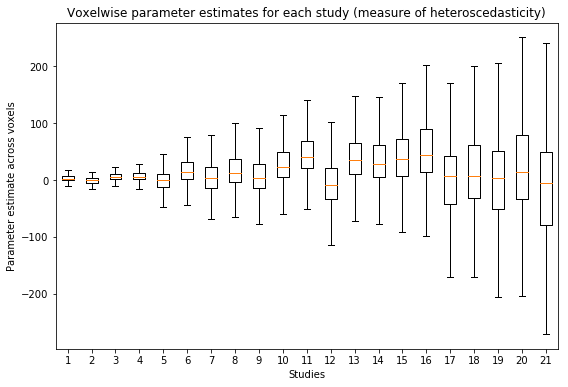

In [40]:
aa = hatbeta.reshape((-1, num_studies))

hatbetas_flat = np.zeros((len(tau2[in_mask].flatten()), num_studies))
for i in range(num_studies):
    this_hatbeta = hatbeta[:,:,:,i]
    hatbetas_flat[:,i] = this_hatbeta[in_mask]
aa = hatbetas_flat
    

aa = aa[:, np.argsort(scipy.stats.iqr(aa, axis=0))]
    
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(aa, 0, sym='')
ax.set_title('Voxelwise parameter estimates for each study (measure of heteroscedasticity)')
plt.xlabel('Studies')
plt.ylabel('Parameter estimate across voxels')

plt.savefig('heteroscedasticity.pdf', format='pdf', dpi=300)

In [17]:
mean_si2 = np.mean(si2, axis=3)
var_si2 = np.var(si2, axis=3)

meansi2_vmax = np.percentile(mean_si2[mean_si2>0], [95])
var_si2_vmax = np.percentile(var_si2[var_si2>0], [95])

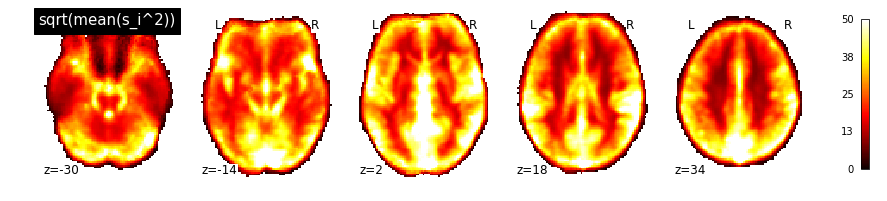

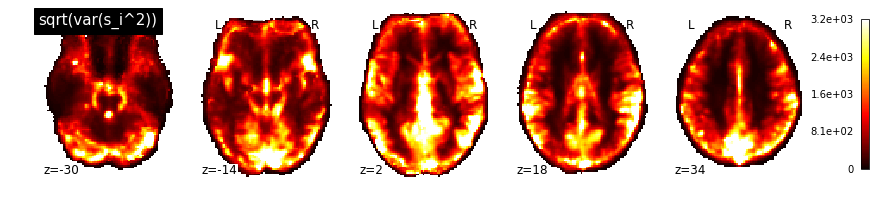

In [18]:
plotting.plot_stat_map(new_img_like(tau2_img, np.sqrt(mean_si2)), colorbar=True, threshold=0, display_mode='z',
                      cut_coords = slices, title='sqrt(mean(s_i^2))', vmax=np.sqrt(meansi2_vmax))


plotting.plot_stat_map(new_img_like(tau2_img, np.sqrt(var_si2)), colorbar=True, threshold=0, display_mode='z',
                      cut_coords = slices, title='sqrt(var(s_i^2))', vmax=np.sqrt(var_si2_vmax))

## Summary statistics

In [19]:
# Mumford 2009: Average over voxels within the interquartile of the nonzero between-study variances
q75, q25 = np.percentile(tau2[tau2>0], [75 ,25])
iqr = q75 - q25

# # interquartile of the nonzero between-study variances
# # boxplot(tau2[tau2>0])
# box_plot(tau2[(tau2<=q75) & (tau2>=q25)])
within_interquartile = np.nonzero((tau2<=q75) & (tau2>=q25))

In [20]:
summary_si2 = np.zeros(num_studies)

for study in range(num_studies):
    this_study_si2 = si2[...,study]
    summary_si2[study] = np.mean(this_study_si2[within_interquartile])
    
scipy.stats.describe(summary_si2)

DescribeResult(nobs=21, minmax=(18.814573287963867, 2310.58349609375), mean=918.75116520836241, variance=657935.35018773924, skewness=0.3345895468337908, kurtosis=-1.3005425576674055)

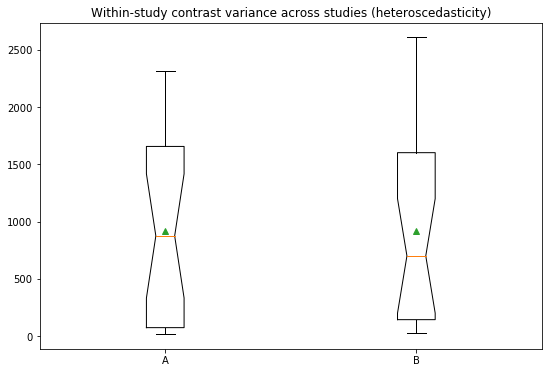

In [21]:
num_subjects_per_study = [25, 25, 20, 20, 9, 9, 9, 12, 12, 12, 12, 13, 32, 24, 14, 14, 12, 12, 16, 16, 16]
within_study_var = np.multiply(summary_si2, num_subjects_per_study)

stacked = (np.stack((summary_si2, within_study_var*np.mean(summary_si2)/np.mean(within_study_var)), axis=1))
# box_plot(stacked)

fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(stacked, 1, showmeans=True)
ax.set_title('Within-study contrast variance across studies (heteroscedasticity)')
xtickNames = plt.setp(ax, xticklabels=('A', 'B'))


## Proportion of within versus between-study variance ($I^2$)

## Map comparisons

In [22]:
def new_inmask_img_like(img, inmask, values):
    new = np.zeros(img.shape)
    
    # We use 0.00001 rathen than zero so that not considered as background in plot_stat_map    
    lim = 0.00001
    values[values<lim] = lim
    
    new[in_mask] = values
    new_img = new_img_like(img, new)
    
    return(new_img)

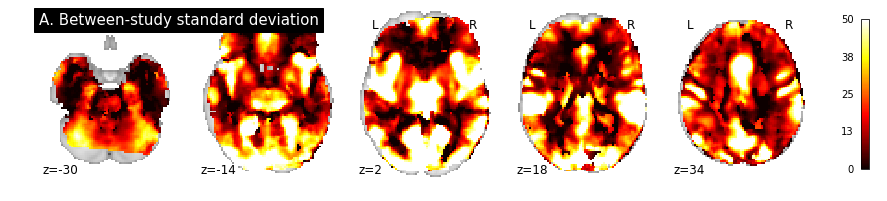

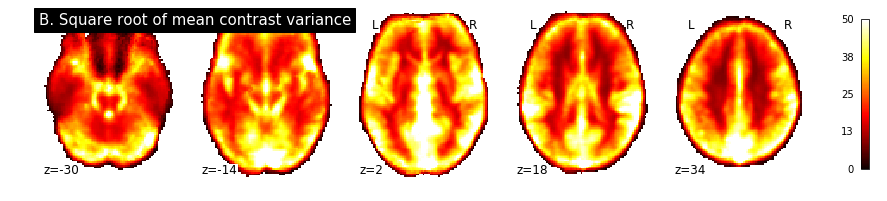

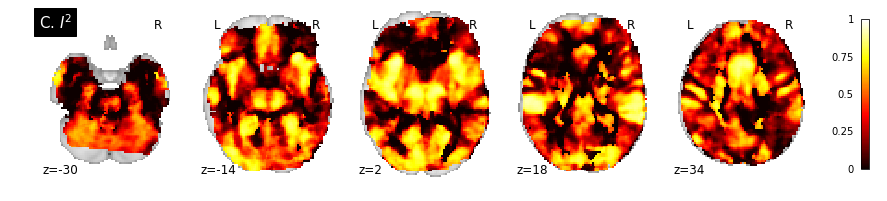

In [34]:
# Root square of the avg squared study standard error
mean_si2 = np.mean(si2, axis=3)

plotting.plot_stat_map(new_img_like(tau2_img, np.sqrt(tau2)), colorbar=True, display_mode='z', 
                      cut_coords = slices, title="A. Between-study standard deviation", vmax=np.sqrt(meansi2_vmax))
plt.savefig('heterogeneity_I2_between.pdf', format='pdf', dpi=300)
plotting.plot_stat_map(new_img_like(tau2_img, np.sqrt(mean_si2)), colorbar=True, display_mode='z', 
                      cut_coords = slices, title="B. Square root of mean contrast variance", vmax=np.sqrt(meansi2_vmax))
plt.savefig('heterogeneity_I2_mean_within.pdf', format='pdf', dpi=300)
i2_img = new_inmask_img_like(tau2_img, in_mask, (tau2[in_mask]/(tau2[in_mask] + mean_si2[in_mask])))
plotting.plot_stat_map(i2_img,
                      colorbar=True, display_mode='z', 
                      cut_coords = slices, title="C. $I^2$", vmax=1)
plt.savefig('heterogeneity_I2.pdf', format='pdf', dpi=300)

In [33]:
### Percentage of voxels with I^2 > 0.5 (i.e. dominating between-study variance)
print(sum(i2_img.get_data()[in_mask]>0.5)/len(in_mask[0])*100)
print(sum(i2_img.get_data()[in_mask]<0.5)/len(in_mask[0])*100)

31.8152024637
68.1847975363


In [36]:
# Quartiles of I^2
print(np.percentile(i2_img.get_data()[in_mask], [75 ,25]))

[ 0.5660429   0.08359909]


DescribeResult(nobs=192232, minmax=(9.9999997473787516e-06, 0.9205363392829895), mean=0.33827675447339367, variance=0.06825334139965053, skewness=0.24845002696150462, kurtosis=-1.2447071005076467)

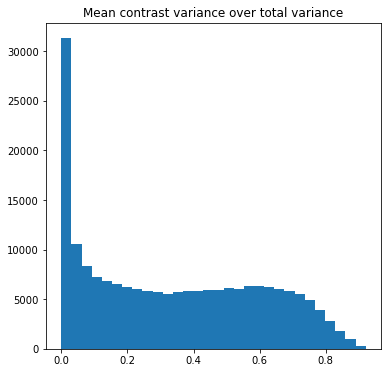

In [24]:
values = i2_img.get_data()[in_mask].flatten()

fig = plt.figure(1, figsize=(6, 6))
ax = fig.add_subplot(111)
bp = ax.hist(values, bins=30)
ax.set_title('Mean contrast variance over total variance')

scipy.stats.describe(values)